# Tutorial Replication

The purpose of this notebook is simply to replicate Matt's tutorial, which can be found [on Panopto](https://ucdenver.hosted.panopto.com/Panopto/Pages/Sessions/List.aspx#folderID=%2265406b5e-52ef-428d-94d9-af6601597a08%22) in [two](https://ucdenver.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=c057cf3a-b1bd-4f85-a0e2-af66015ed850) [parts](https://ucdenver.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=b2e63522-720c-48e4-956a-af6901740c79). This will help us get an idea of how the syntax differs between pure ROOT and the Jupyter kernel implementation.

In [1]:
import uproot
import glob
import math
import numpy as np
import pandas as pd
import datetime as dt
import lmfit as lf
import matplotlib.pyplot as plt
from matplotlib import cm
#%matplotlib inline

(161790, 301)
['DetType', 'Empty', 'PAINTall', 'PAOFamps', 'PAOFamps0', 'PAOFchisq', 'PAOFchisqLF', 'PAOFdelay', 'PATFPamp', 'PATFPchisq', 'PATFPeflag', 'PATFPint', 'PATFPoffset', 'PATFPtau', 'PAWKf20', 'PAWKf40', 'PAWKf80', 'PAWKf90', 'PAWKf95', 'PAWKmax', 'PAWKr10', 'PAWKr100', 'PAWKr20', 'PAWKr30', 'PAWKr40', 'PAWKr50', 'PAWKr60', 'PAWKr70', 'PAWKr80', 'PAWKr90', 'PAWKr95', 'PAbias', 'PAbs', 'PAbspost', 'PAgain', 'PAnorm', 'PAsat', 'PAstd', 'PBINTall', 'PBOFamps', 'PBOFamps0', 'PBOFchisq', 'PBOFchisqLF', 'PBOFdelay', 'PBTFPamp', 'PBTFPchisq', 'PBTFPeflag', 'PBTFPint', 'PBTFPoffset', 'PBTFPtau', 'PBWKf20', 'PBWKf40', 'PBWKf80', 'PBWKf90', 'PBWKf95', 'PBWKmax', 'PBWKr10', 'PBWKr100', 'PBWKr20', 'PBWKr30', 'PBWKr40', 'PBWKr50', 'PBWKr60', 'PBWKr70', 'PBWKr80', 'PBWKr90', 'PBWKr95', 'PBbias', 'PBbs', 'PBbspost', 'PBgain', 'PBnorm', 'PBsat', 'PBstd', 'PCINTall', 'PCOFamps', 'PCOFamps0', 'PCOFchisq', 'PCOFchisqLF', 'PCOFdelay', 'PCTFPamp', 'PCTFPchisq', 'PCTFPeflag', 'PCTFPint', 'PCTFPoff

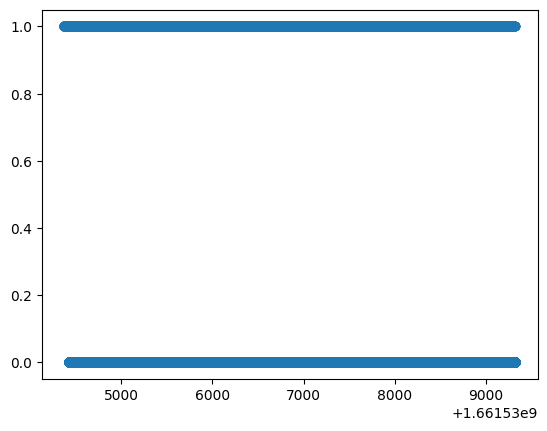

In [2]:
datapath ="R76Data/"
ser = ["07220822_1828","07220826_1219","07220826_1536","07220826_2007","07220827_1153","07220830_1724"]
lab = ["0V","-4V","-21V","-65V","-84V","-84V"]
#As a Chain is a collection of Trees, 
#I am approximating the chain as a list of Trees.
nser = 6; e = []; z = [];
for s in range(nser):
    e_chain = pd.DataFrame(); z_chain = pd.DataFrame();
    for file in glob.glob(datapath+ser[s]+"/umn*root"):
        if e_chain.empty: #For first entry, generate columns
            e_chain = pd.concat([e_chain,uproot.open(file)["rqDir/eventTree"].pandas.df()],axis=1)
            z_chain = pd.concat([z_chain,uproot.open(file)["rqDir/zip1"].pandas.df()],axis=1)
        else:
            e_chain = pd.concat([e_chain,uproot.open(file)["rqDir/eventTree"].pandas.df()],ignore_index=True)
            z_chain = pd.concat([z_chain,uproot.open(file)["rqDir/zip1"].pandas.df()],ignore_index=True)
    e.append(e_chain); z.append(z_chain)
    
#friends are complicated. here's the docs page on tchain friends: 
#https://root.cern/doc/master/classTChain.html#a967c9e4e14e314b46e4c11bc6a1c2353
#I think this is a reasonable approximation of them
for i,x in enumerate(z):
    z[i] = pd.concat([x,e[i]],axis=1)

print(z[0].shape)
print(list(z[0]))

plt.scatter(z[1]['EventTime'],z[1]['EventCategory'])
plt.show()

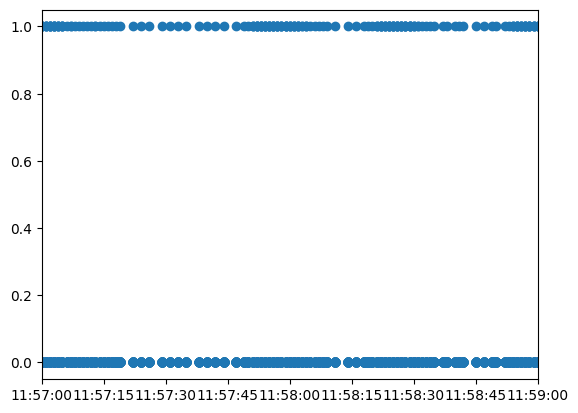

In [3]:
timestamps = [dt.datetime.fromtimestamp(x) for x in z[1]['EventTime'].values]
plt.scatter(timestamps,z[1]['EventCategory'])

#plt.xlim(dt.datetime(2020,8,26,11,56).timestamp(),dt.datetime(2020,8,26,12,00).timestamp())
#plt.xlim(pd.to_datetime("2020-08-26 11:56"),pd.to_datetime("2020-08-26 12:00"))

plt.xlim(pd.to_datetime("2022-08-26 11:57"),pd.to_datetime("2022-08-26 11:59"))
plt.show()

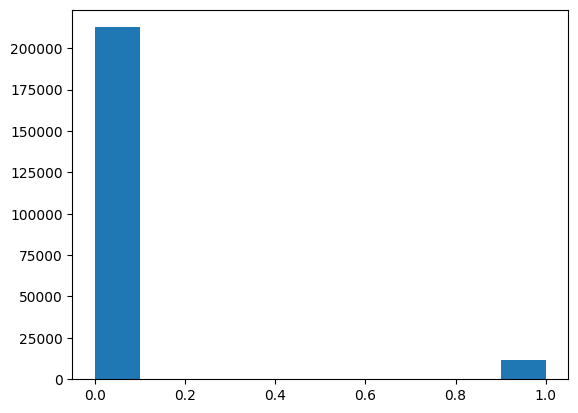

In [4]:
#I don't see a better way to handle the aliases than to simply add a pandas column.
#Unfortunately this means that we will have to rerun this cell if anything the aliases depends on changes.
for x in z:
    x['PTwid'] = (x['PTWKf40'] - x['PTWKr40'])*1e6
    x['xdel'] = 1e6*(x['PEWKr20'] - 0.5*(x['PCWKr20']+x['PDWKr20']))-1
    x['ydel'] = 1e6*(0.866*(x['PDWKr20'] - x['PCWKr20']))+9
    x['phidel'] = [180/np.pi*math.atan2(x['ydel'].array[j],x['xdel'].array[j]) for j in range(len(x['ydel'].array))]
    x['afdel'] = 1e6*(x['PFWKr20']-x['PAWKr20'])
    
plt.hist(z[1]['EventCategory'])
plt.show()

In [5]:
nentries = np.zeros(10); timestart = np.zeros(10); timeend = np.zeros(10);
crand = []; ctime0 = []; cam = []; cgoodwalk = [];
for i,x in enumerate(z):
    nentries[i] = x.shape[0]
    timestart[i] = e[i]['EventTime'].array[1000]
    timeend[i] = e[i]['EventTime'].array[-1]
    crand.append(z[i]['EventCategory']==1)
    ctime0.append(z[i].index > 60000)
    cam.append(z[i]['PFOFamps']/z[i]['PTOFamps']>0.21)
    cgoodwalk.append((z[i]['PCWKr20'] > 0.25e-3)
                     & (z[i]['PCWKr20']<0.5e-3)
                     & (z[i]['PDWKr20']>0.25e-3)
                     & (z[i]['PDWKr20']<0.5e-3)
                     & (z[i]['PEWKr20']>0.25e-3)
                     & (z[i]['PEWKr20']<0.5e-3))
timestart[0] = e[0]["EventTime"][60001]
timesec = timeend - timestart

161790 33685


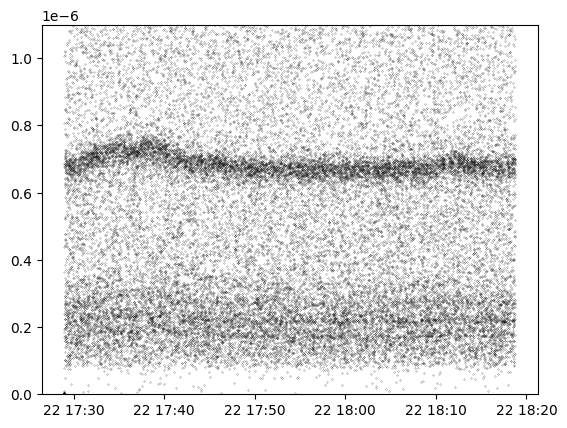

In [6]:
#print(len(~crand[0]),len(cam[0]))
print(len(z[0]['PTOFamps']),len(z[0]['PTOFamps'][~crand[0].array & cam[0]]))
timestamps = [dt.datetime.fromtimestamp(x) for x in z[0]['EventTime'].values[~crand[0] & cam[0]]]
plt.scatter(timestamps,z[0]['PTOFamps'][~crand[0] & cam[0]],marker='.',s=0.1,color='k')

plt.ylim(0,1.1e-6)
plt.show()

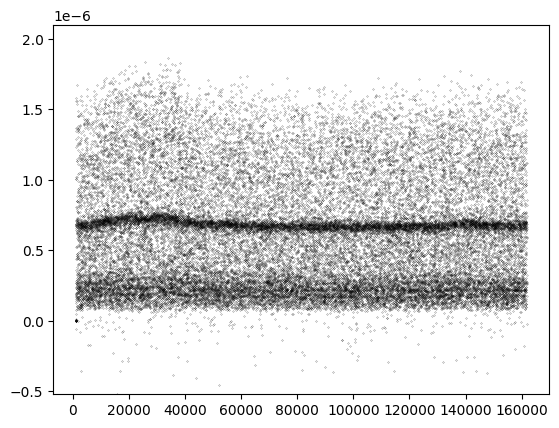

In [7]:
plt.scatter(z[0].index[~crand[0] & cam[0]],z[0]['PTOFamps'][~crand[0] & cam[0]],marker='.',s=0.1,color='k')

plt.ylim(-0.52e-6,2.1e-6)
#plt.xlim(0,180e3)
plt.show()

200
20


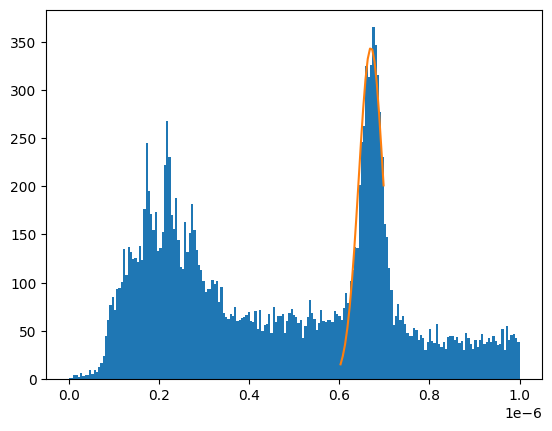

In [8]:
withcut = z[0]["PTOFamps"][~crand[0] & cam[0] & ctime0[0]]
bins = np.linspace(0,1e-6,200)
hspec0 = plt.hist(withcut,bins=bins)
def gauss(x,A=1,mu=0,sigma=1):
    return A/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x-mu)**2/(2*sigma**2))
subbins = bins[(bins >= 0.6e-6) & (bins <= 0.7e-6)]
print(len(hspec0[1]))
subdata = hspec0[0][(bins[:-1] >= 0.6e-6) & (bins[:-1] <= 0.7e-6)]
print(len(subdata))

gaussmod = lf.Model(gauss)
gaussparams = gaussmod.make_params(mu=0.675e-6)
gaussparams.add('sigma',value=1e-6,min=0)
gaussparams.add('A',value=1,min=0)
gaussfit = gaussmod.fit(subdata,gaussparams,weights=np.sqrt(subdata),x=subbins)

plt.plot(subbins,gaussfit.best_fit)
plt.show()

gaussfit

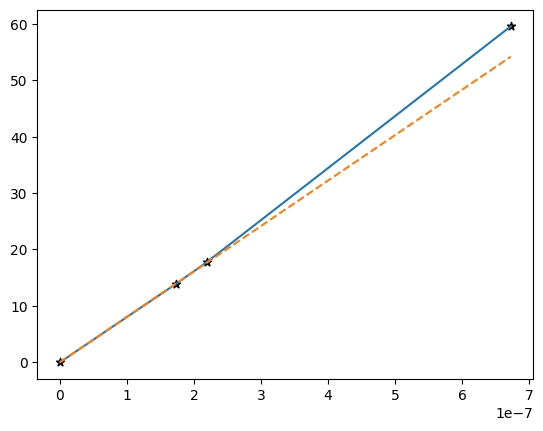

In [9]:
gcal = [[0,1.73263e-07,2.19449e-07,6.72661e-07],[0,13.95,17.74,59.54]]
plt.scatter(gcal[0],gcal[1],marker="*",color='k')

def cal(x,a=1,b=1):
    return a*x+b*x**2

calmod = lf.Model(cal)
calparams = calmod.make_params()
calparams.add('a',value=60/7e-7,min=0)
calparams.add('b',value=1e20,min=0) #Start large to give it a push in the right direction
calfit = calmod.fit(gcal[1],calparams,x=gcal[0])

plt.plot(gcal[0],calfit.best_fit)
plt.plot(gcal[0],13.95*np.asarray(gcal[0])/1.73263e-07,linestyle='--')

plt.show()

calfit

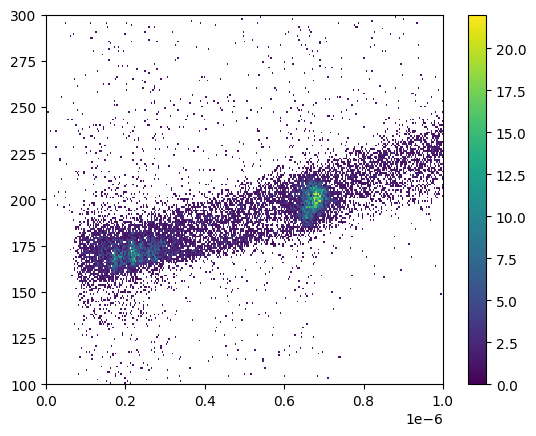

In [10]:
try:
    pt_keV[0] = calfit.best_values['a']*z[0]["PTOFamps"]+calfit.best_values['b']*z[0]["PTOFamps"]**2
except NameError:
    pt_keV = [calfit.best_values['a']*z[0]["PTOFamps"]+calfit.best_values['b']*z[0]["PTOFamps"]**2]

fig = plt.figure()

cmap = cm.viridis.copy()
cmap.set_under('w')

h = plt.hist2d(z[0]["PTOFamps"][~crand[0] & cam[0] & ctime0[0]],
               z[0]["PTwid"][~crand[0] & cam[0] & ctime0[0]],
               bins=[np.linspace(0,1e-6,300),np.linspace(100,300,200)],cmap=cmap,vmin=1e-10)
                #force white bg instead of purple to help comparison.

fig.colorbar(h[3])
plt.show() #Hard to tell if this is quite right... but it seems okay for now

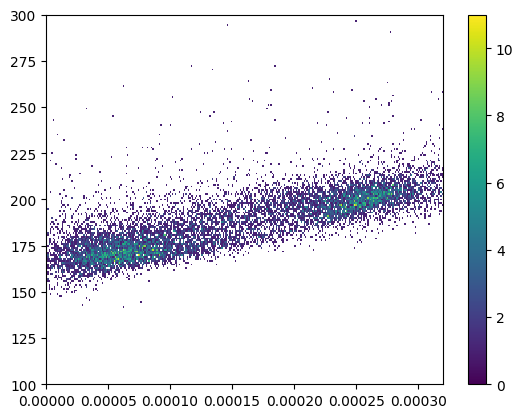

In [11]:
fig = plt.figure()

cmap = cm.viridis.copy()
cmap.set_under('w')

h = plt.hist2d(z[0]["PTINTall"][~crand[0] & cam[0] & ctime0[0]],
               z[0]["PTwid"][~crand[0] & cam[0] & ctime0[0]],
               bins=[np.linspace(0,0.32e-3,300),np.linspace(100,300,200)],cmap=cmap,vmin=1e-10)
                #force white bg instead of purple to help comparison.

fig.colorbar(h[3])
plt.show()

In [12]:
cgood = [];
cgood.append(ctime0[0])
for i,x in enumerate(z):
    if i>0:
        cgood.append(np.ones(x.shape[0]))

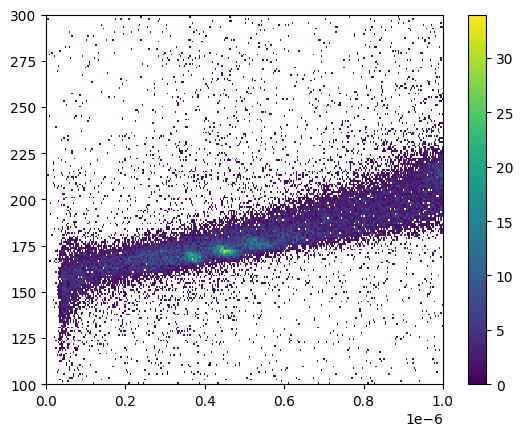

In [13]:
fig = plt.figure()

cmap = cm.viridis.copy()
cmap.set_under('w')

h = plt.hist2d(z[1]["PTOFamps"][~crand[1] & cam[1] & ctime0[1]],
               z[1]["PTwid"][~crand[1] & cam[1] & ctime0[1]],
               bins=[np.linspace(0,1e-6,300),np.linspace(100,300,200)],cmap=cmap,vmin=1e-10)
                #force white bg instead of purple to help comparison.

fig.colorbar(h[3])
plt.show()

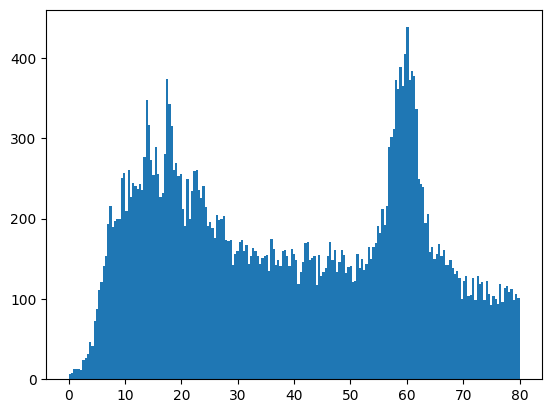

In [14]:
h0 = plt.hist(pt_keV[0][~crand[0] & ctime0[0]],bins=np.linspace(0,80,200))
plt.show()

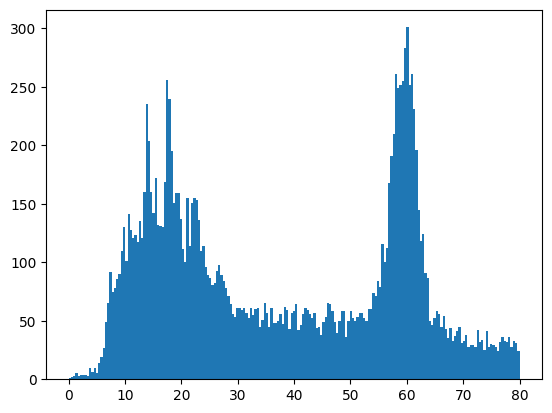

In [15]:
plt.hist(pt_keV[0][~crand[0] & ctime0[0] & cam[0]],bins=np.linspace(0,80,200))
plt.show()

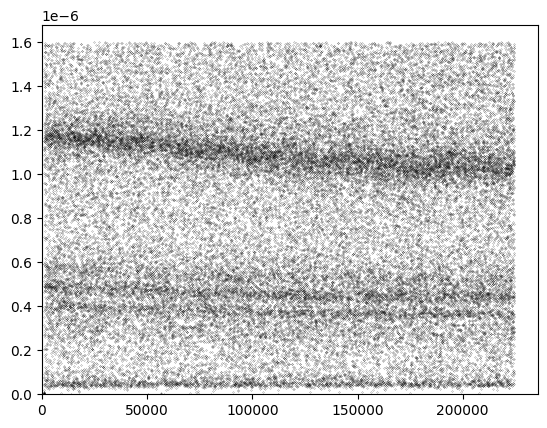

In [16]:
cam[1] = z[1]["PFOFamps"]/z[1]["PTOFamps"] > 0.26

plt.scatter(z[1].index[~crand[1] & cam[1] & (z[1]["PTOFamps"] > 0) & (z[1]["PTOFamps"] < 1.6e-6)],
            z[1]["PTOFamps"][~crand[1] & cam[1] & (z[1]["PTOFamps"] > 0) & (z[1]["PTOFamps"] < 1.6e-6)],
            s=0.02,color='k')

plt.ylim(0); plt.xlim(0)
plt.show()

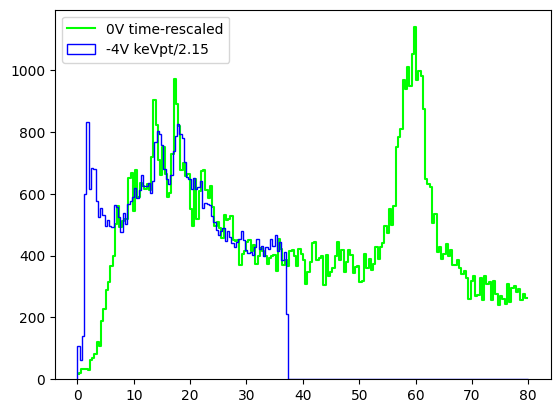

In [17]:
try:
    pt_keV[1] = 7.73882e+07*z[1]["PTOFamps"]+1.653756e+13*z[1]["PTOFamps"]**2
except IndexError:
    pt_keV.append(7.73882e+07*z[1]["PTOFamps"]+1.653756e+13*z[1]["PTOFamps"]**2)

plt.step((h0[1][:-1]+h0[1][1:])/2,h0[0]*timesec[1]/timesec[0],color='lime',label="0V time-rescaled")
h1 = plt.hist(np.asarray(pt_keV[1])[(np.asarray(pt_keV[1])<80) & ~crand[1]]/2.15,
         bins=np.linspace(0,80,200),histtype='step',color='blue',label="-4V keVpt/2.15")#,linewidth=2)
plt.legend()
plt.show()

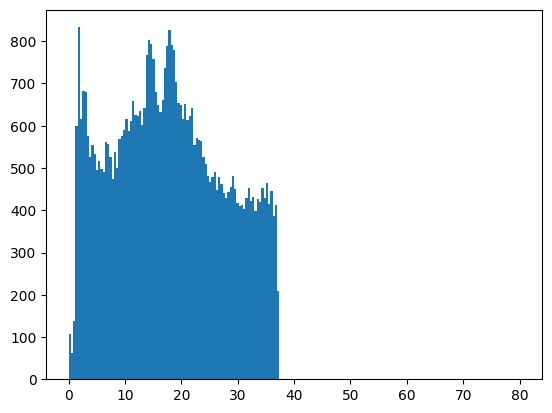

In [18]:
plt.hist(pt_keV[1][~crand[1] & (pt_keV[1]<80)]/2.15,bins=np.linspace(0,80,200))
plt.show()

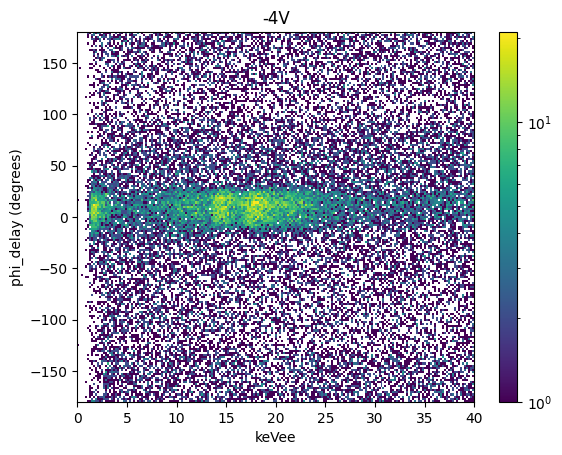

In [19]:
fig = plt.figure()
h = plt.hist2d(pt_keV[1][~crand[1] & cgoodwalk[1]]/2.15,
               z[1]["phidel"][~crand[1] & cgoodwalk[1]],
               bins=[np.linspace(0,40,200),np.linspace(-180,180,180)],
               cmap=cmap,norm='log')
                #force white bg instead of purple to help comparison.

plt.title("-4V")
plt.xlabel("keVee")
plt.ylabel("phi_delay (degrees)")
    
fig.colorbar(h[3])
plt.show()

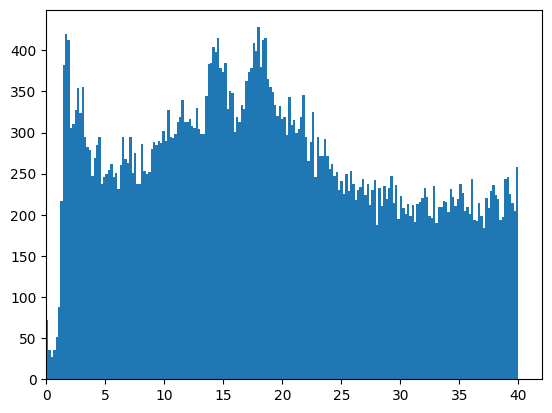

In [20]:
plt.hist(pt_keV[1][~crand[1]]/2.15,bins=np.linspace(0,40,200))
plt.xlim(0)
plt.show()

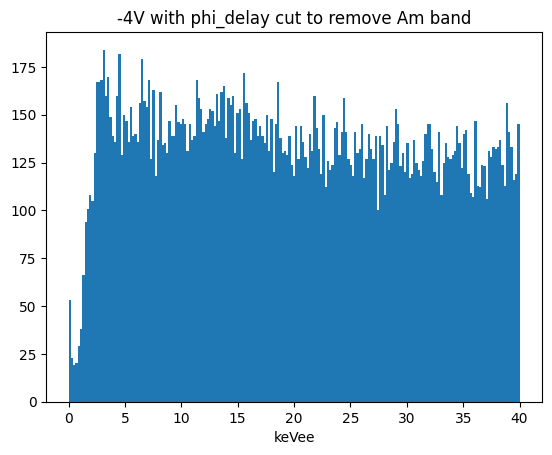

In [32]:
plt.hist(pt_keV[1][~crand[1] & ~((z[1]["phidel"]>-40) & (z[1]["phidel"]<60))]/2.15,bins=np.linspace(0,40,200))
plt.title("-4V with phi_delay cut to remove Am band")
plt.xlabel("keVee")
plt.show()

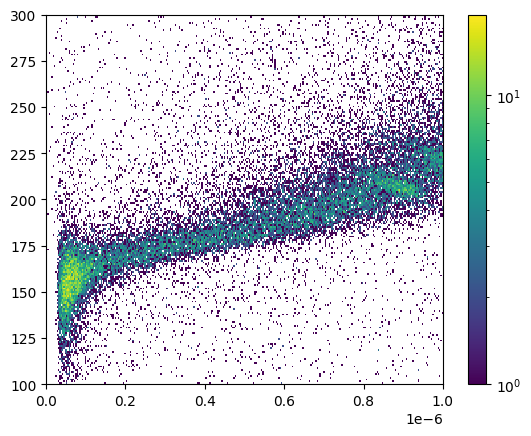

In [33]:
fig = plt.figure()
h = plt.hist2d(z[2]["PTOFamps"][~crand[2]],z[2]["PTwid"][~crand[2]],
           bins=(np.linspace(0,1e-6,300),np.linspace(100,300,200)),cmap=cmap,norm="log")
fig.colorbar(h[3])
plt.show()

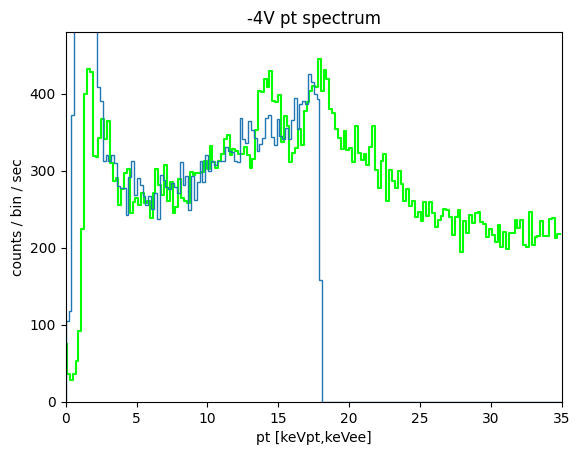

In [34]:
try:
    pt_keV[2] = 7.738820e+07*z[2]["PTOFamps"]+1.653756e+13*z[2]["PTOFamps"]**2
except IndexError:
    pt_keV.append(7.738820e+07*z[2]["PTOFamps"]+1.653756e+13*z[2]["PTOFamps"]**2)
try:
    pt0_keV[2] = 7.738820e+07*z[2]["PTOFamps0"]+1.653756e+13*z[2]["PTOFamps0"]**2
except NameError:
    pt0_keV = [[],[],7.738820e+07*z[2]["PTOFamps0"]+1.653756e+13*z[2]["PTOFamps0"]**2]

h1 = np.histogram(pt_keV[1][~crand[1]]/2.15,bins=np.linspace(0,35,175));
fig = plt.figure()
    
plt.step((h1[1][:-1]+h1[1][1:])/2,h1[0]*timesec[2]/timesec[1],color='lime',label="-4V keVpt/2.15 time-rescaled")
h2 = plt.hist(pt_keV[2][~crand[2] & (pt_keV[2]<80)]/4.45,bins=np.linspace(0,35,175),histtype='step')

plt.title("-4V pt spectrum")
plt.xlabel("pt [keVpt,keVee]");plt.ylabel("counts / bin / sec")
plt.xlim(0,35);plt.ylim(0,480)
plt.show()

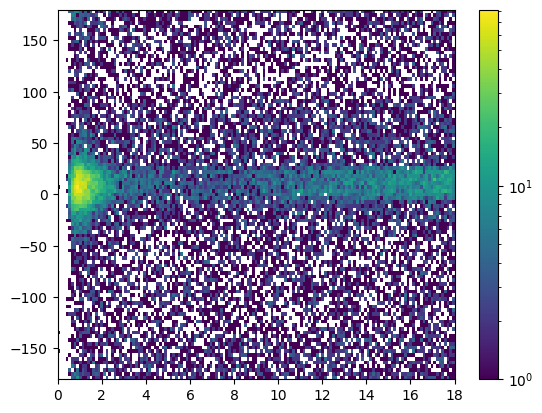

In [35]:
fig = plt.figure()
h = plt.hist2d(pt_keV[2][~crand[2] & cgoodwalk[2]]/4.45,z[2]["phidel"][~crand[2] & cgoodwalk[2]],
           bins=(np.linspace(0,18,150),np.linspace(-180,180,100)),norm="log")
fig.colorbar(h[3])
plt.show()

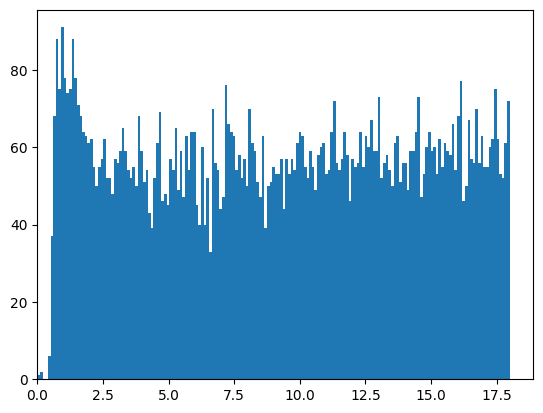

In [36]:
plt.hist(pt_keV[2][~crand[2] & ~((z[2]["phidel"]>-50)&(z[2]["phidel"]<80)) & cgoodwalk[2]]/4.45,
         bins=np.linspace(0,18,180))
plt.xlim(0)
plt.show()

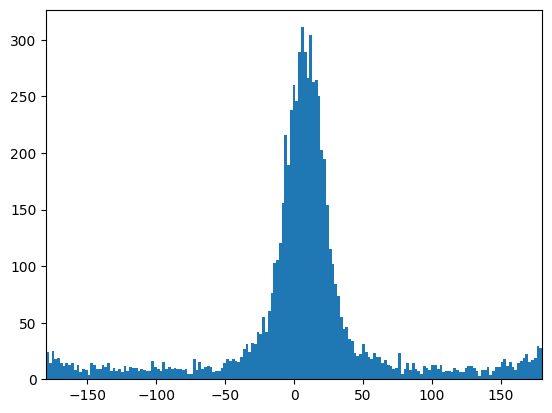

In [37]:
plt.hist(z[2]["phidel"][~crand[2] & cgoodwalk[2] & (pt_keV[2]/4.45 > 0.4) & (pt_keV[2]/4.15 < 2.5)],
         bins=np.linspace(-180,180,180))
plt.xlim(-180,180)
plt.show()

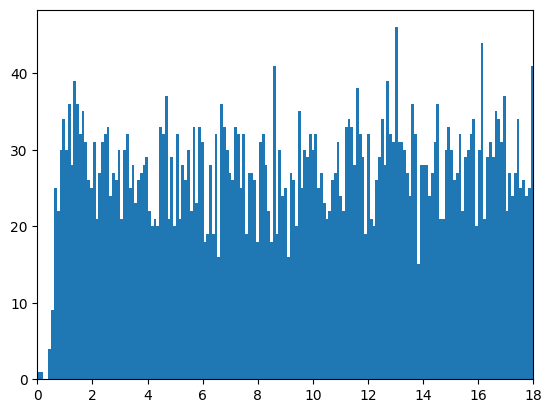

In [38]:
for x in z:
    x["c2phi"] = ((x["phidel"] > -160) & (x["phidel"] < -50)) | ((x["phidel"] > 70) & (x["phidel"] < 50))
    
plt.hist(pt_keV[2][~crand[2] & cgoodwalk[2] & z[2]["c2phi"]]/4.45,bins=np.linspace(0,18,180))
plt.xlim(0,18)
plt.show()

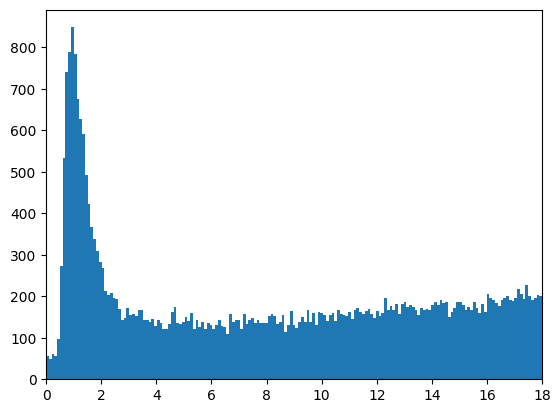

In [51]:
h2 = plt.hist(pt_keV[2][~crand[2]]/4.45,bins=np.linspace(0,18,180))
plt.xlim(0,18)
plt.show()

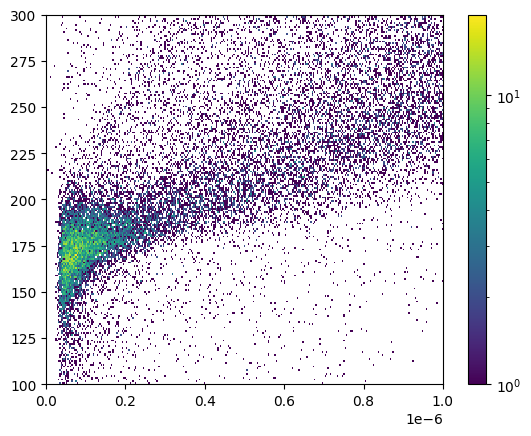

In [52]:
fig = plt.figure()
h = plt.hist2d(z[3]["PTOFamps"][~crand[3]],z[3]["PTwid"][~crand[3]],
           bins=(np.linspace(0,1e-6,300),np.linspace(100,300,200)),norm="log")
fig.colorbar(h[3])
plt.show()

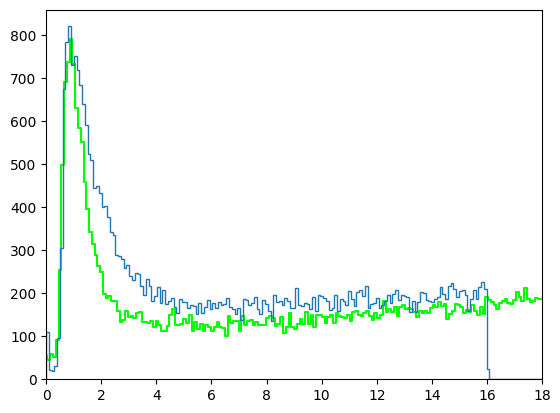

In [55]:
try:
    pt_keV[3] = 7.738820e+07*z[3]["PTOFamps"]+1.653756e+13*z[3]["PTOFamps"]**2
except IndexError:
    pt_keV.append(7.738820e+07*z[3]["PTOFamps"]+1.653756e+13*z[3]["PTOFamps"]**2)
try:
    pt0_keV[3] = 7.738820e+07*z[3]["PTOFamps0"]+1.653756e+13*z[3]["PTOFamps0"]**2
except IndexError:
    pt0_keV.append(7.738820e+07*z[3]["PTOFamps0"]+1.653756e+13*z[3]["PTOFamps0"]**2)

plt.step((h2[1][:-1]+h2[1][1:])/2,h2[0]*timesec[3]/timesec[2],color='lime')
h3 = plt.hist(pt_keV[3][~crand[3] & (pt_keV[3]<80)]/5,bins=np.linspace(0,18,180),histtype='step')
plt.xlim(0,18); plt.ylim(0,860)
plt.show()

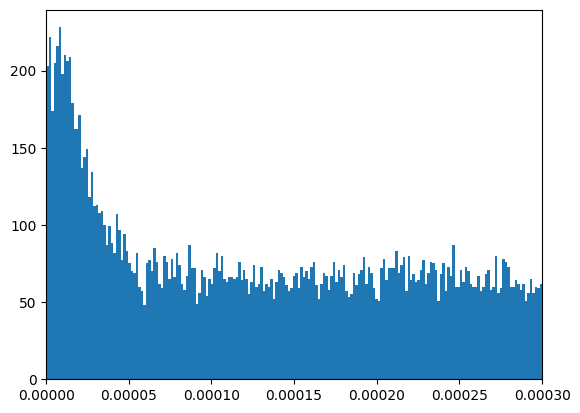

In [58]:
h2i = plt.hist(z[2]["PTINTall"][~crand[2] & (pt_keV[2]<80)],bins=np.linspace(0,0.0003,200))
plt.xlim(0,0.0003)
plt.show()

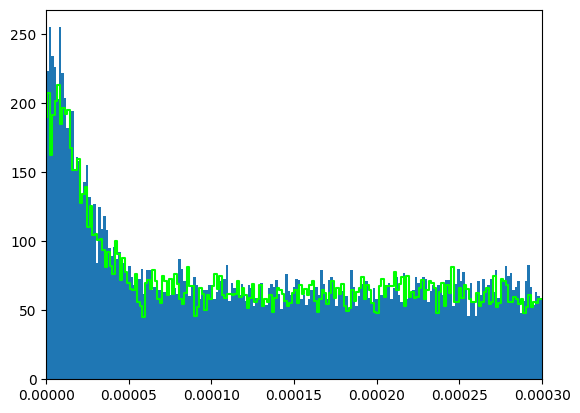

In [59]:
plt.step((h2i[1][:-1]+h2i[1][1:])/2,h2i[0]*timesec[3]/timesec[2],color='lime')
plt.hist(z[3]["PTINTall"][~crand[3]]/1.5,bins=np.linspace(0,0.0003,200))

plt.xlim(0,0.0003)
plt.show()

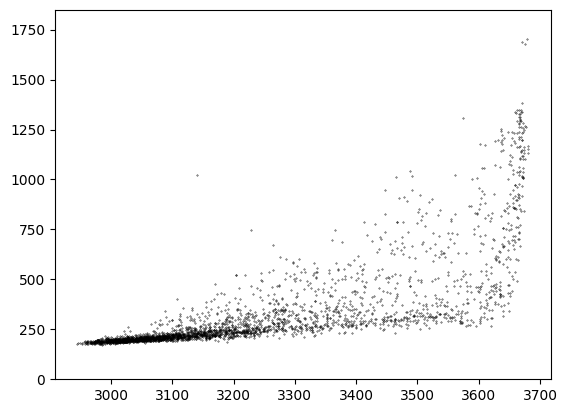

In [63]:
plt.scatter(z[3]["PFbs"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)],
            z[3]["PTwid"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)],
           s=0.1,color='k')
plt.ylim(0,1850)
plt.show()

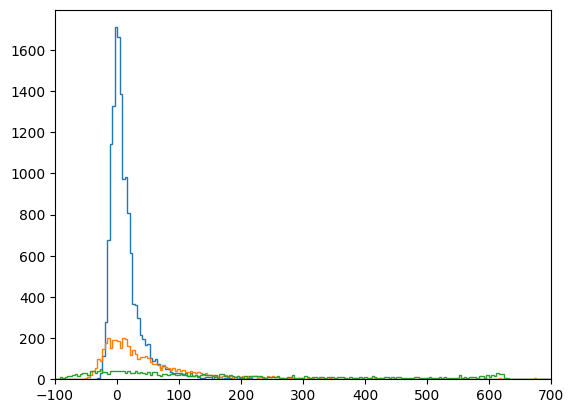

In [66]:
h1bs = plt.hist(z[1]["PFbs"][~crand[1] & (z[1]["PTINTall"]>0.1e-3) & (z[1]["PTINTall"]<0.2e-3)] - 3026,
         bins = np.linspace(-100,700,200),histtype="step")
h2bs = plt.hist(z[2]["PFbs"][~crand[2] & (z[2]["PTINTall"]>0.1e-3) & (z[2]["PTINTall"]<0.2e-3)] - 2935,
         bins = np.linspace(-100,700,200),histtype="step")
h3bs = plt.hist(z[3]["PFbs"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)] - 3050,
         bins = np.linspace(-100,700,200),histtype="step")
plt.xlim(-100,700)
plt.show()

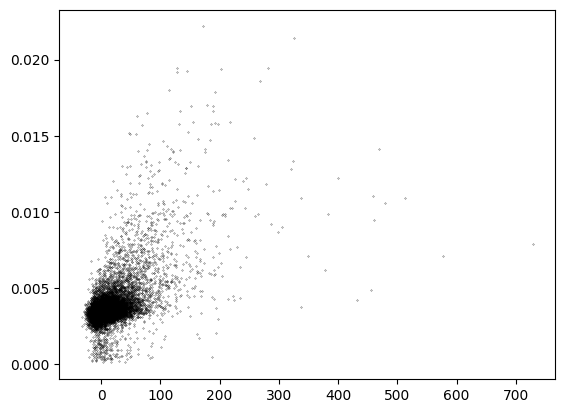

In [75]:
plt.scatter(z[1]["PFbs"][~crand[1] & (z[1]["PTINTall"]>0.1e-3) & (z[1]["PTINTall"]<0.2e-3)] - 3026, 
            z[1]["PTOFamps"][~crand[1] & (z[1]["PTINTall"]>0.1e-3) & (z[1]["PTINTall"]<0.2e-3)]/z[1]["PTINTall"][~crand[1] & (z[1]["PTINTall"]>0.1e-3) & (z[1]["PTINTall"]<0.2e-3)],
           s=0.05,color='k')
plt.show()

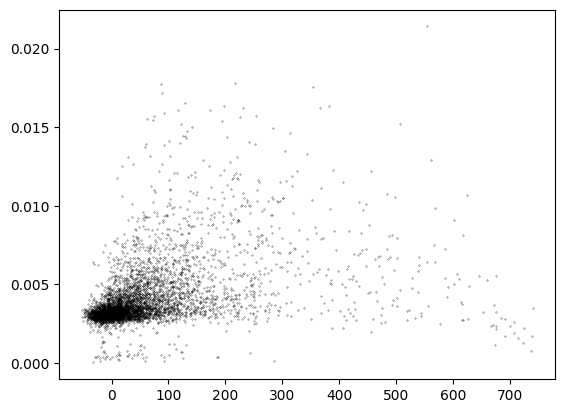

In [78]:
plt.scatter(z[2]["PFbs"][~crand[2] & (z[2]["PTINTall"]>0.1e-3) & (z[2]["PTINTall"]<0.2e-3)] - 2935, 
            z[2]["PTOFamps"][~crand[2] & (z[2]["PTINTall"]>0.1e-3) & (z[2]["PTINTall"]<0.2e-3)]/z[2]["PTINTall"][~crand[2] & (z[2]["PTINTall"]>0.1e-3) & (z[2]["PTINTall"]<0.2e-3)],
           s=0.05,color='k')
plt.show()

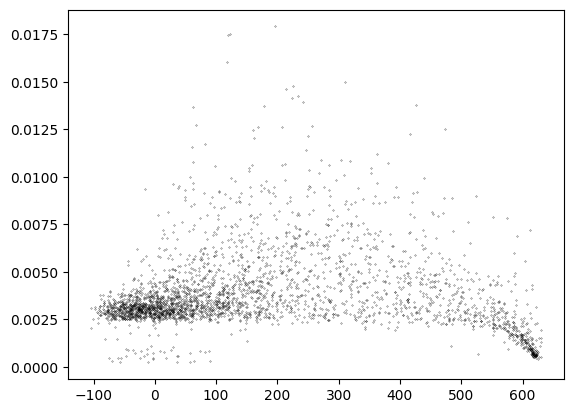

In [79]:
plt.scatter(z[3]["PFbs"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)] - 3050, 
            z[3]["PTOFamps"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)]/z[3]["PTINTall"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)],
           s=0.05,color='k')
plt.show()

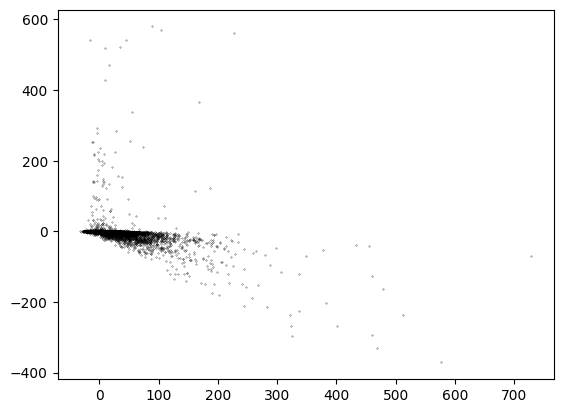

In [81]:
c3bs = z[3]["PFbs"] - 3050 < 540
plt.scatter(z[1]["PFbs"][~crand[1] & (z[1]["PTINTall"]>0.1e-3) & (z[1]["PTINTall"]<0.2e-3)]-3026,
            z[1]["PFbspost"][~crand[1] & (z[1]["PTINTall"]>0.1e-3) & (z[1]["PTINTall"]<0.2e-3)] 
            - z[1]["PFbs"][~crand[1] & (z[1]["PTINTall"]>0.1e-3) & (z[1]["PTINTall"]<0.2e-3)],
           s=0.05,color='k')

plt.show()

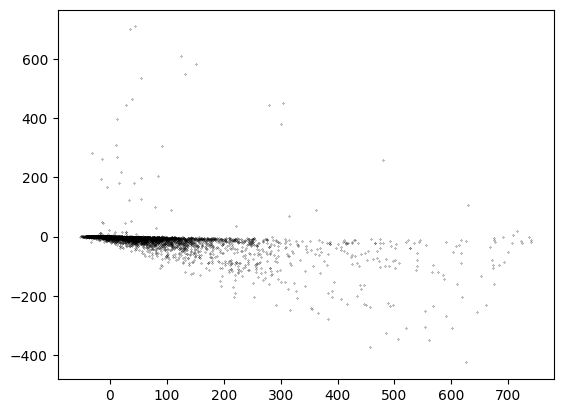

In [82]:
plt.scatter(z[2]["PFbs"][~crand[2] & (z[2]["PTINTall"]>0.1e-3) & (z[2]["PTINTall"]<0.2e-3)]-2935,
            z[2]["PFbspost"][~crand[2] & (z[2]["PTINTall"]>0.1e-3) & (z[2]["PTINTall"]<0.2e-3)] 
            - z[2]["PFbs"][~crand[2] & (z[2]["PTINTall"]>0.1e-3) & (z[2]["PTINTall"]<0.2e-3)],
           s=0.05,color='k')

plt.show()

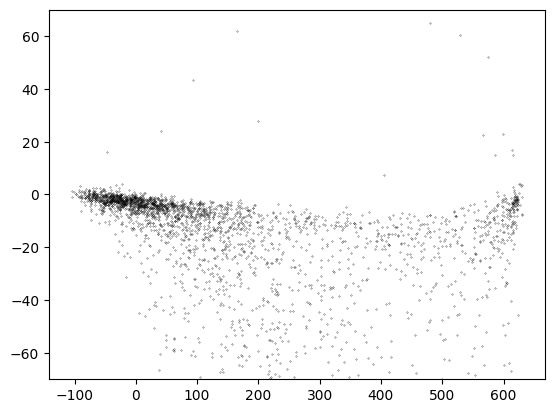

In [84]:
plt.scatter(z[3]["PFbs"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)]-3050,
            z[3]["PFbspost"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)] 
            - z[3]["PFbs"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)],
           s=0.05,color='k')
plt.ylim(-70,70)
plt.show()

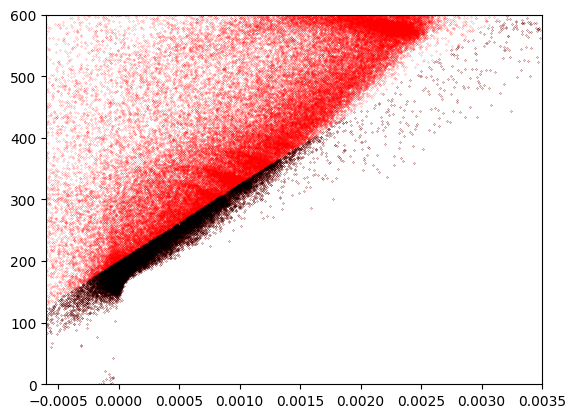

In [95]:
c2wid = z[2]["PTwid"]<180 + 125000*z[2]["PTINTall"]
c3wid = z[3]["PTwid"]<200 + 125000*z[3]["PTINTall"]
plt.scatter(z[3]["PTINTall"][~crand[3] & cgoodwalk[3]],z[3]["PTwid"][~crand[3] & cgoodwalk[3]],
           s=0.02,color='r')
plt.scatter(z[3]["PTINTall"][~crand[3] & cgoodwalk[3] & c3wid],
            z[3]["PTwid"][~crand[3] & cgoodwalk[3] & c3wid],s=0.02,color='k')
plt.ylim(0,600);plt.xlim(-0.0006,0.0035)
plt.show()

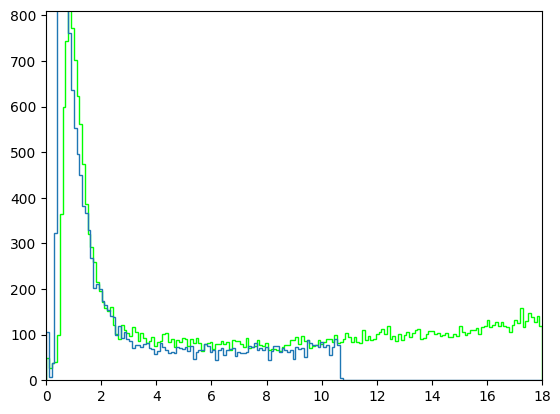

In [98]:
fig = plt.figure()

h2w = plt.hist(pt_keV[2][~crand[2] & c2wid]/4.45*timesec[3]/timesec[2],bins=np.linspace(0,18,180),
              color='lime',histtype='step')
h3w = plt.hist(pt_keV[3][~crand[3] & c3wid & (pt_keV[3]<80)]/7.5,bins=np.linspace(0,18,180),histtype='step')

plt.xlim(0,18);plt.ylim(0,810)
plt.show()

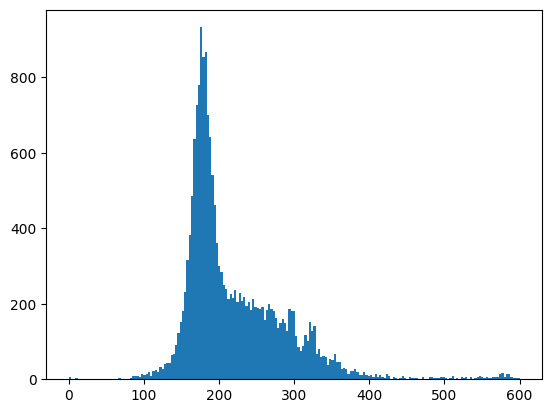

In [100]:
plt.hist(z[3]["PTwid"][~crand[3] & cgoodwalk[3] & c3wid],bins=np.linspace(0,600,200))
plt.show()

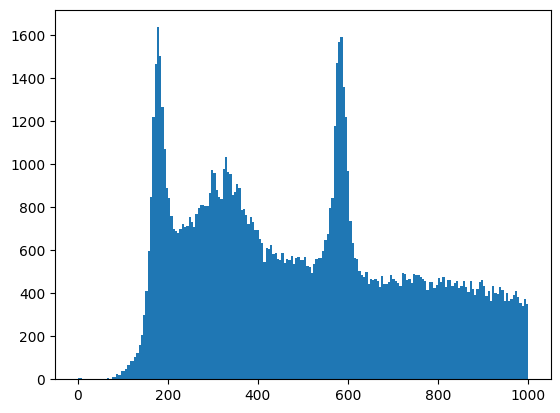

In [101]:
plt.hist(z[3]["PTwid"][~crand[3] & cgoodwalk[3]],bins=np.linspace(0,1000,200))
plt.show()

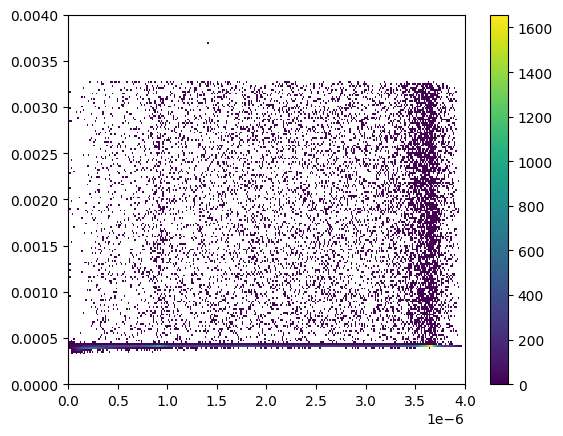

In [112]:
fig = plt.figure()
h = plt.hist2d(z[0]["PTWKmax"][~crand[0]],z[0]["PTWKr50"][~crand[0]],
           bins=(np.linspace(0,4e-6,300),np.linspace(0,0.004,200)),cmap=cmap,vmin=1e-10)
fig.colorbar(h[3])
plt.show()

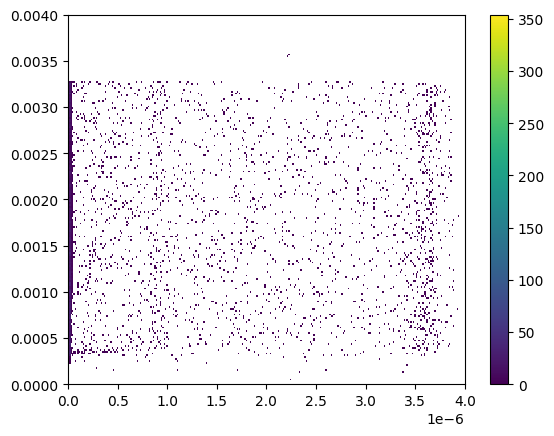

In [113]:
fig = plt.figure()
h = plt.hist2d(z[0]["PTWKmax"][crand[0]],z[0]["PTWKr50"][crand[0]],
           bins=(np.linspace(0,4e-6,300),np.linspace(0,0.004,200)),cmap=cmap,vmin=1e-10)
fig.colorbar(h[3])
plt.show()

In [123]:
print(len(crand[0][crand[0]]))
print(len(crand[0][crand[0] & (z[0]["PTWKmax"] > 0.5e-6) & (z[0]["PTWKr50"]>0.0005) & (z[0]["PTWKr50"] < 0.003)]))
twindow = 0.003-0.0005
rate_rand = math.log(15345/(15345-1727))/twindow
print(rate_rand)
print(len(crand[0][~crand[0] & ctime0[0] & (z[0]["PTWKmax"]>0.5e-6)]))
rate_trig = 78339/timesec[0]
print(rate_trig)
effic_write = rate_trig/rate_rand
print(effic_write)

15345
1727
47.75889640436981
78339
41.5812101910828
0.8706484722556997


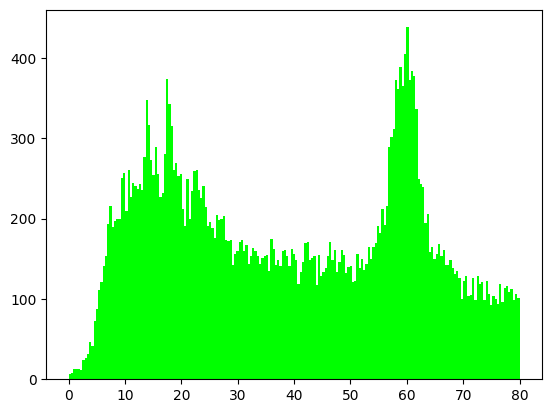

In [124]:
plt.hist(pt_keV[0][~crand[0] & ctime0[0]],bins=np.linspace(0,80,200),color='lime')
plt.show()

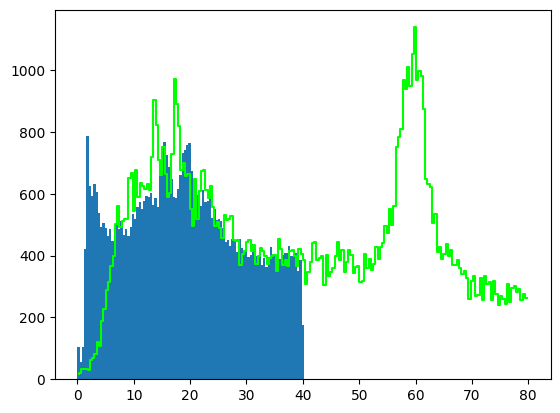

In [126]:
pt_keV[1] = 7.738820e+07*z[1]["PTOFamps"] + 1.653756e+13*z[1]["PTOFamps"]**2

plt.step((h0[1][:-1]+h0[1][1:])/2,h0[0]*timesec[1]/timesec[0],color='lime')
h1 = plt.hist(pt_keV[1][~crand[1] & (pt_keV[1]<80)]/2.,bins=np.linspace(0,80,200))

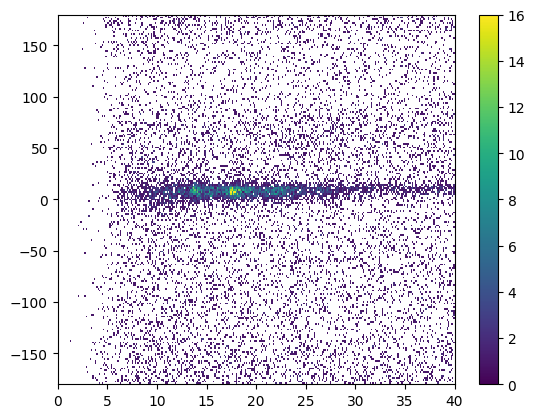

In [130]:
fig = plt.figure()
h = plt.hist2d(pt_keV[0][~crand[0] & ctime0[0] & cgoodwalk[0]],z[0]["phidel"][~crand[0] & ctime0[0] & cgoodwalk[0]],
           bins=(np.linspace(0,40,300),np.linspace(-180,180,200)),cmap=cmap,vmin=1e-10)
fig.colorbar(h[3])
plt.show()

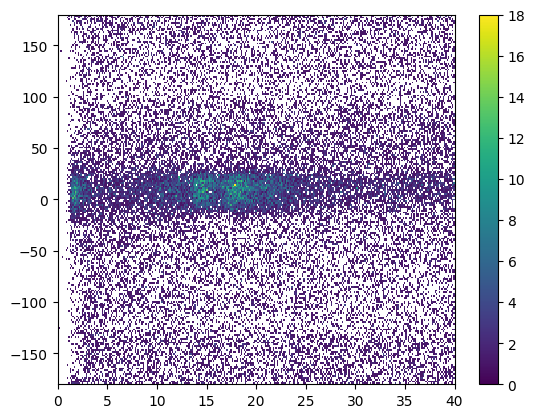

In [132]:
fig = plt.figure()
h = plt.hist2d(pt_keV[1][~crand[1] & cgoodwalk[1]]/2.15,z[1]["phidel"][~crand[1] & cgoodwalk[1]],
           bins=(np.linspace(0,40,300),np.linspace(-180,180,200)),cmap=cmap,vmin=1e-10)
fig.colorbar(h[3])
plt.show()

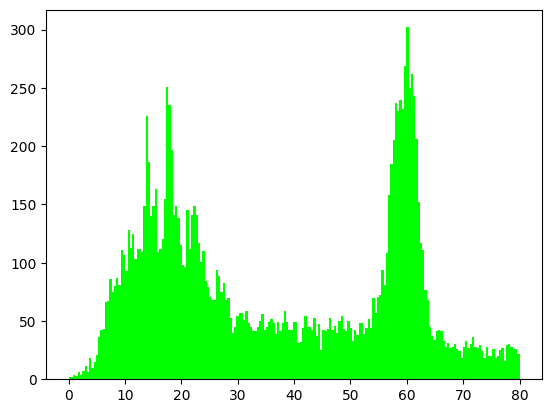

In [137]:
camphi = []
for x in z:
    camphi.append((x["phidel"]>-30) & (x["phidel"]<50))
    
h0am = plt.hist(pt_keV[0][~crand[0] & ctime0[0] & camphi[0]],bins=np.linspace(0,80,200),color='lime')
plt.show()

At this point, I've stopped frequently encountering issues -- so I think I have the hang of things. No need to continue replicating <i>everything</i>; we should move on to trying out cdmsbats.